In [128]:
import numpy as np
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import stopwords.
from nltk.corpus import stopwords # Import the stop word list

from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup 
import regex as re
from sklearn.model_selection import cross_val_score

# Import confusion matrix.
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor,RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

In [129]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [130]:
# adding variable stopwords from other notebook

%store -r stopwords

In [131]:
from sklearn.feature_extraction import text

text.ENGLISH_STOP_WORDS

my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

In [132]:
df = pd.read_csv('clean_comments.csv')

In [133]:
df.shape

(16549, 2)

In [134]:
df.isna().sum()

body      152
target      0
dtype: int64

In [135]:
df.dropna(inplace=True)

In [136]:
df.isna().sum()

body      0
target    0
dtype: int64

In [137]:
df.shape

(16397, 2)

In [138]:
df.head()

,body,target
0,lebron such idiot for using the word misinform...,1
1,maybe should sent somewhere educated how think...,1
2,the change with china going happen when it eco...,1
3,fucking clown cannot believe ill informed dang...,1
4,apologized for hurt feeling not great but nowh...,1


In [139]:
X = df['body']
y = df['target']

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [141]:
# Base line score 58.5%

y.value_counts(normalize=True)

0    0.585046
1    0.414954
Name: target, dtype: float64

### Most Common Words by Subreddit

Text(0.5, 1.0, 'Word Frequency: Rockets')

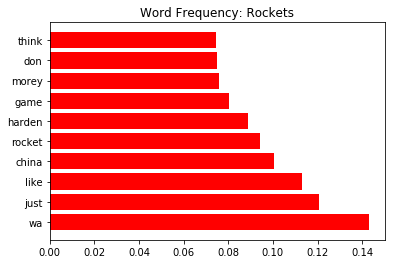

In [142]:
rockets_words = list(df.body[(df.target == 1)])

rcvec = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = 'english', 
                             max_features = 35) 

r_cv = rcvec.fit_transform(rockets_words)

rockets_words = pd.DataFrame(r_cv.todense(), columns=rcvec.get_feature_names())

r_coef = rockets_words.mean().sort_values(ascending=False)[:10]

plt.barh(r_coef.index, r_coef.values, color='r')
plt.title('Word Frequency: Rockets')

Text(0.5, 1.0, 'Word Frequency: Rockets')

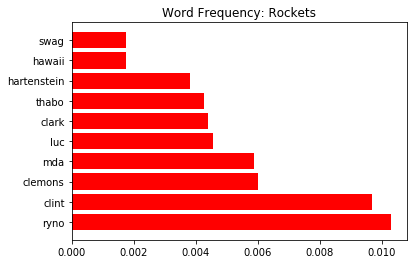

In [143]:
rockets_words = list(df.body[(df.target == 1)])

rcvec = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = my_stop_words, 
                             max_features = 35) 

r_cv = rcvec.fit_transform(rockets_words)

rockets_words = pd.DataFrame(r_cv.todense(), columns=rcvec.get_feature_names())

r_coef = rockets_words.mean().sort_values(ascending=False)[:10]

plt.barh(r_coef.index, r_coef.values, color='r')
plt.title('Word Frequency: Rockets')

Text(0.5, 1.0, 'Word Frequency: NBA')

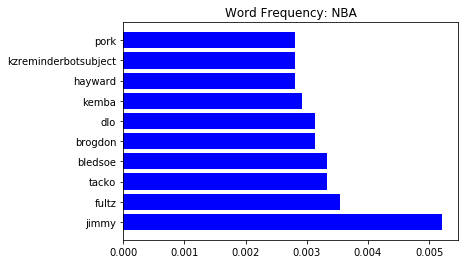

In [144]:
rockets_words = list(df.body[(df.target == 0)])

rcvec = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = my_stop_words, 
                             max_features = 35) 

r_cv = rcvec.fit_transform(rockets_words)

rockets_words = pd.DataFrame(r_cv.todense(), columns=rcvec.get_feature_names())

r_coef = rockets_words.mean().sort_values(ascending=False)[:10]

plt.barh(r_coef.index, r_coef.values, color='b')
plt.title('Word Frequency: NBA')

Text(0.5, 1.0, 'Word Frequency: NBA')

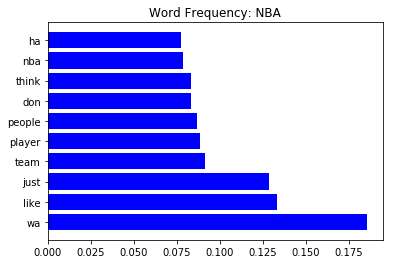

In [145]:
rockets_words = list(df.body[(df.target == 0)])

rcvec = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = 'english', 
                             max_features = 35) 

r_cv = rcvec.fit_transform(rockets_words)

rockets_words = pd.DataFrame(r_cv.todense(), columns=rcvec.get_feature_names())

r_coef = rockets_words.mean().sort_values(ascending=False)[:10]

plt.barh(r_coef.index, r_coef.values, color='b')
plt.title('Word Frequency: NBA')

### Logistic Regression, Cvec with stopwords

In [146]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer(stop_words=my_stop_words)

# Fit the vectorizer on our corpus.
cvec.fit(X_train)

# Transform the corpus.
X_train = cvec.transform(X_train)

# Convert X_train into a DataFrame.

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())

# Transform test
X_test = cvec.transform(X_test)
X_test_df = pd.DataFrame(X_test.toarray(),
                         columns=cvec.get_feature_names())

# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# 1. An instance of CountVectorizer (transformer)
# 2. A LogisticRegression instance (estimator)

cvec_lr_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=my_stop_words)),
    ('lr', LogisticRegression())
])

cvec_lr_pipe_params = {
    'cvec__max_features': [75000, None],
    'cvec__ngram_range': [(1,1), (1,2)],
}

# Instantiate GridSearchCV.

lrcv_gs = GridSearchCV(cvec_lr_pipe, # what object are we optimizing?
                  cvec_lr_pipe_params, # what parameters values are we searching?
                  cv=3,    # 3-fold cross-validation.
                 verbose=1) 


# Fit GridSearch to training data.
lrcv_gs.fit(X_train, y_train);

# Save best model as gs_model.
lrcv_gs_model = lrcv_gs.best_estimator_

# Best Parameters
print(f'Gridsearch Best Params: {lrcv_gs.best_params_}')

# Test and Train Scores
print(f'Lr and Cvec Training Score:{lrcv_gs_model.score(X_train, y_train)}')
print(f'Lr and Cvec Testing Score:{lrcv_gs_model.score(X_test, y_test)}')

coef = lrcv_gs_model.named_steps['lr'].coef_
features = lrcv_gs_model.named_steps['cvec'].get_feature_names

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.8s finished


Gridsearch Best Params: {'cvec__max_features': 75000, 'cvec__ngram_range': (1, 1)}
Lr and Cvec Training Score:0.7466545289030496
Lr and Cvec Testing Score:0.6577974870657798


In [52]:
result_df = pd.DataFrame(lrcv_gs_model.named_steps['lr'].coef_, 
                         columns=lrcv_gs_model.named_steps['cvec'].get_feature_names(),
                         index=['target']).T

In [53]:
result_df.sort_values(by='target', ascending=False)

,target
rus,2.297220
clint,2.279343
rocket,1.969049
mda,1.864539
clown,1.859201
...,...
kanter,-1.527790
kyrie,-1.591948
luka,-1.612909
simmons,-1.710782


In [54]:
# Confusion Matrix for Logistic Regression and Cvec

lrcv_best_score = lrcv_gs_model

preds = lrcv_best_score.predict(X_test)

# Generate predictions.
cm = confusion_matrix(y_test, preds)

# Convert confusion matrix to dataframe
cm_df = pd.DataFrame(cm,
                    columns = ['predicted neg', 'predicted pos'],
                    index = ['actual neg', 'actual pos'])
cm_df

,predicted neg,predicted pos
actual neg,2638,528
actual pos,1099,1147


### Logistic Regression with TFID and stop words

In [102]:
# Instantiate a CountVectorizer.
tvec = TfidfVectorizer(stop_words=my_stop_words)

# Fit the vectorizer on our corpus.
tvec.fit(X_train)

# Transform the corpus.
X_train = tvec.transform(X_train)

# Convert X_train into a DataFrame.

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=tvec.get_feature_names())

# Transform test
X_test = tvec.transform(X_test)
X_test_df = pd.DataFrame(X_test.toarray(),
                         columns=tvec.get_feature_names())

# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# 1. An instance of CountVectorizer (transformer)
# 2. A LogisticRegression instance (estimator)

tvec_lr_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=my_stop_words)),
    ('lr', LogisticRegression())
])

tvec_lr_pipe_params = {
    'tvec__max_features': [10000, None],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__use_idf': [True, False]
}

# Instantiate GridSearchCV.

lrtv_gs = GridSearchCV(tvec_lr_pipe, # what object are we optimizing?
                  tvec_lr_pipe_params, # what parameters values are we searching?
                  cv=3,       # 3-fold cross-validation.
                 verbose=1) 

# Fit GridSearch to training data.
lrtv_gs.fit(X_train, y_train);

# Save best model as gs_model.
lrtv_gs_model = lrtv_gs.best_estimator_

# Best Parameters
print(f'Gridsearch Best Params: {lrtv_gs.best_params_}')

# Test and Train Scores
print(f'Lr and Tvec Training Score:{lrtv_gs_model.score(X_train, y_train)}')
print(f'Lr and Tvec Testing Score:{lrtv_gs_model.score(X_test, y_test)}')



Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    3.3s finished


Gridsearch Best Params: {'tvec__max_features': 10000, 'tvec__ngram_range': (1, 1), 'tvec__use_idf': True}
Lr and Tvec Training Score:0.7466545289030496
Lr and Tvec Testing Score:0.6533628972653363


In [87]:
result_df = pd.DataFrame(lrtv_gs_model.named_steps['lr'].coef_, 
                         columns=lrtv_gs_model.named_steps['tvec'].get_feature_names(),
                         index=['target']).T

In [88]:
result_df.sort_values(by='target', ascending=False)

,target
rocket,5.057189
rus,4.697021
harden,3.813086
morey,3.055177
clint,2.999588
...,...
klay,-1.910276
kyrie,-2.056223
kawhi,-2.133535
simmons,-2.341947


### Random Forest and CVEC

In [62]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor,RandomForestClassifier, ExtraTreesClassifier

In [103]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer(stop_words=my_stop_words)

# Fit the vectorizer on our corpus.
cvec.fit(X_train)

# Transform the corpus.
X_train = cvec.transform(X_train)

# Convert X_train into a DataFrame.

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())

# Transform test
X_test = cvec.transform(X_test)
X_test_df = pd.DataFrame(X_test.toarray(),
                         columns=cvec.get_feature_names())

# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# 1. An instance of CountVectorizer (transformer)
# 2. A LogisticRegression instance (estimator)

cvec_rf_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=my_stop_words)),
    ('rf', RandomForestClassifier())
])

cvec_rf_pipe_params = {
    'cvec__max_features': [75000, None],
    'cvec__ngram_range': [(1,2)],
    'rf__n_estimators': [10] 
}

# Instantiate GridSearchCV.

rfcv_gs = GridSearchCV(cvec_rf_pipe, # what object are we optimizing?
                  cvec_rf_pipe_params, # what parameters values are we searching?
                  n_jobs=-1,
                  cv=3, # 3-fold cross-validation.
                 verbose=1) 

# Fit GridSearch to training data.
rfcv_gs.fit(X_train, y_train);

# Save best model as gs_model.
rfcv_gs_model = rfcv_gs.best_estimator_

# Best Parameters
print(f'Gridsearch Best Params: {rfcv_gs.best_params_}')

# Test and Train Scores
print(f'Rf and Cvec Training Score:{rfcv_gs_model.score(X_train, y_train)}')
print(f'Rf and Cvec Testing Score:{rfcv_gs_model.score(X_test, y_test)}')

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.1s finished


Gridsearch Best Params: {'cvec__max_features': None, 'cvec__ngram_range': (1, 2), 'rf__n_estimators': 10}
Rf and Cvec Training Score:0.7466545289030496
Rf and Cvec Testing Score:0.6566888396156689


### Random Forest and TVEC

In [104]:
# Instantiate a CountVectorizer.
tvec = TfidfVectorizer(stop_words=my_stop_words)

# Fit the vectorizer on our corpus.
tvec.fit(X_train)

# Transform the corpus.
X_train = tvec.transform(X_train)

# Convert X_train into a DataFrame.

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=tvec.get_feature_names())

# Transform test
X_test = tvec.transform(X_test)
X_test_df = pd.DataFrame(X_test.toarray(),
                         columns=tvec.get_feature_names())

# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# 1. An instance of CountVectorizer (transformer)
# 2. A LogisticRegression instance (estimator)

tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=my_stop_words)),
    ('rf', RandomForestClassifier())
])

tvec_rf_pipe_params = {
    'tvec__max_features': [10000, None],
    'tvec__ngram_range': [(1,2)],
}

# Instantiate GridSearchCV.

rftv_gs = GridSearchCV(tvec_rf_pipe, # what object are we optimizing?
                  tvec_rf_pipe_params, # what parameters values are we searching?
                  n_jobs=-1,
                  cv=3,# 3-fold cross-validation.
                 verbose=1) 

# Fit GridSearch to training data.
rftv_gs.fit(X_train, y_train);

# Save best model as gs_model.
rftv_gs_model = rftv_gs.best_estimator_

# Best Parameters
print(f'Gridsearch Best Params: {rftv_gs.best_params_}')

# Test and Train Scores
print(f'Rf and Tvec Training Score:{rftv_gs_model.score(X_train, y_train)}')
print(f'Rf and Tvec Testing Score:{rftv_gs_model.score(X_test, y_test)}')

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.8s finished
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Gridsearch Best Params: {'tvec__max_features': 10000, 'tvec__ngram_range': (1, 2)}
Rf and Tvec Training Score:0.7321802457897132
Rf and Tvec Testing Score:0.6535476718403548


## Multinomial Naive Bayes with CVEC

A Naive Bayes model assumes that each of the features it uses are conditionally independent of one another given some class.

The term Multinomial Naive Bayes simply lets us know that each feature is a multinomial distribution, rather than some other distribution. 
This works well for data which can easily be turned into counts, such as word counts in text.

In [65]:
# initialize
cvec = CountVectorizer(stop_words = my_stop_words)
mnb = MultinomialNB()

pipe = Pipeline([
    ('cvec', cvec),
    ('mnb', mnb)
])

In [66]:
# baseline MultinomialNB model

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.8369594902139281
test score: 0.6971544715447154


In [105]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer(stop_words=my_stop_words)

# Fit the vectorizer on our corpus.
cvec.fit(X_train)

# Transform the corpus.
X_train = cvec.transform(X_train)

# Convert X_train into a DataFrame.

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())

# Transform test
X_test = cvec.transform(X_test)
X_test_df = pd.DataFrame(X_test.toarray(),
                         columns=cvec.get_feature_names())

# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# 1. An instance of CountVectorizer (transformer)
# 2. A LogisticRegression instance (estimator)

cvec_mnb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=my_stop_words)),
    ('mnb', MultinomialNB())
])

cvec_mnb_pipe_params = {
    'cvec__max_features': [75000, None], 
    'cvec__ngram_range': [(1, 1)], 
    'mnb__alpha': [0, 0.25, 0.5, 0.75, 1]
}

# Instantiate GridSearchCV.

mnbcv_gs = GridSearchCV(cvec_mnb_pipe, # what object are we optimizing?
                  cvec_mnb_pipe_params, # what parameters values are we searching?
                  cv=3,    # 3-fold cross-validation.
                 verbose=1) 


# Fit GridSearch to training data.
mnbcv_gs.fit(X_train, y_train);

# Save best model as gs_model.
mnbcv_gs_model = mnbcv_gs.best_estimator_

# Best Parameters
print(f'Gridsearch Best Params: {mnbcv_gs.best_params_}')

# Test and Train Scores
print(f'MNB and Cvec Training Score:{mnbcv_gs_model.score(X_train, y_train)}')
print(f'MNB and Cvec Testing Score:{mnbcv_gs_model.score(X_test, y_test)}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will res

Gridsearch Best Params: {'cvec__max_features': 75000, 'cvec__ngram_range': (1, 1), 'mnb__alpha': 0}
MNB and Cvec Training Score:0.7466545289030496
MNB and Cvec Testing Score:0.6655580192165558


In [93]:
result_df = pd.DataFrame(mnbcv_gs_model.named_steps['mnb'].coef_, 
                         columns=mnbcv_gs_model.named_steps['cvec'].get_feature_names(),
                         index=['target']).T

In [94]:
result_df.sort_values(by='target', ascending=False)

,target
rocket,-4.803114
harden,-4.870818
morey,-4.991322
chinese,-5.316954
rus,-5.578564
...,...
ergodan,-10.896684
playstation,-10.896684
playoffbound,-10.896684
eriously,-10.896684


### Multinomial Naive Bayes with TFID

In [71]:
# initialize
tvec = TfidfVectorizer(stop_words = my_stop_words)
mnb = MultinomialNB()

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

# baseline MultinomialNB model

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.7969048702776513
test score: 0.6792313377679231


In [106]:
# Instantiate a CountVectorizer.
tvec = TfidfVectorizer(stop_words=my_stop_words)

# Fit the vectorizer on our corpus.
tvec.fit(X_train)

# Transform the corpus.
X_train = tvec.transform(X_train)

# Convert X_train into a DataFrame.

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=tvec.get_feature_names())

# Transform test
X_test = cvec.transform(X_test)
X_test_df = pd.DataFrame(X_test.toarray(),
                         columns=tvec.get_feature_names())

# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# 1. An instance of CountVectorizer (transformer)
# 2. A LogisticRegression instance (estimator)

tvec_mnb_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=my_stop_words)),
    ('mnb', MultinomialNB())
])

tvec_mnb_pipe_params = {
    'tvec__max_features': [5000, 10000], 
    'tvec__ngram_range': [(1, 1)], 
    'mnb__alpha': [0, 0.25, 0.5, 0.75, 1]
}

# Instantiate GridSearchCV.

mnbtv_gs = GridSearchCV(tvec_mnb_pipe, # what object are we optimizing?
                  tvec_mnb_pipe_params, # what parameters values are we searching?
                  cv=3,    # 3-fold cross-validation.
                 verbose=1) 


# Fit GridSearch to training data.
mnbtv_gs.fit(X_train, y_train);

# Save best model as gs_model.
mnbtv_gs_model = mnbtv_gs.best_estimator_

# Best Parameters
print(f'Gridsearch Best Params: {mnbtv_gs.best_params_}')

# Test and Train Scores
print(f'MNB and Tvec Training Score:{mnbtv_gs_model.score(X_train, y_train)}')
print(f'MNB and Tvec Testing Score:{mnbtv_gs_model.score(X_test, y_test)}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/dylan/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will res

Gridsearch Best Params: {'mnb__alpha': 0, 'tvec__max_features': 10000, 'tvec__ngram_range': (1, 1)}
MNB and Tvec Training Score:0.7466545289030496
MNB and Tvec Testing Score:0.6655580192165558


In [96]:
result_df = pd.DataFrame(mnbtv_gs_model.named_steps['mnb'].coef_, 
                         columns=mnbtv_gs_model.named_steps['tvec'].get_feature_names(),
                         index=['target']).T

In [97]:
result_df.sort_values(by='target', ascending=False)

,target
rocket,-5.185980
harden,-5.240515
morey,-5.444053
rus,-5.667364
fuck,-5.744321
...,...
dellavedova,-10.367915
restraint,-10.367915
restraunt,-10.367915
restricted,-10.367915


## Visual of Model Performances

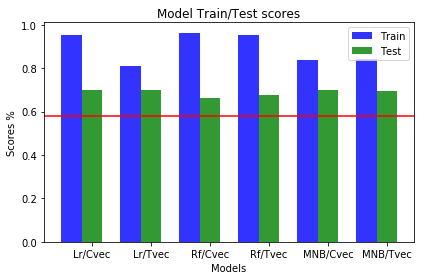

In [81]:
# Taken from documentation on matplotlib bar graphs

# data to plot
n_groups = 6

Training_Scores = (lrcv_gs_model.score(X_train, y_train), lrtv_gs_model.score(X_train, y_train),
          rfcv_gs_model.score(X_train, y_train), rftv_gs_model.score(X_train, y_train),
         mnbcv_gs_model.score(X_train, y_train), mnbtv_gs_model.score(X_train, y_train))

Testing_Scores = (lrcv_gs_model.score(X_test, y_test), lrtv_gs_model.score(X_test, y_test),
          rfcv_gs_model.score(X_test, y_test), rftv_gs_model.score(X_test, y_test),
         mnbcv_gs_model.score(X_test, y_test), mnbtv_gs_model.score(X_test, y_test))

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, Training_Scores, bar_width,
alpha=opacity,
color='b',
label='Train')

rects2 = plt.bar(index + bar_width, Testing_Scores, bar_width,
alpha=opacity,
color='g',
label='Test')

plt.xlabel('Models')
plt.ylabel('Scores %')
plt.title('Model Train/Test scores')
plt.xticks(index + bar_width, ('Lr/Cvec', 'Lr/Tvec', 'Rf/Cvec', 'Rf/Tvec', 'MNB/Cvec', 'MNB/Tvec'))
plt.axhline(y=.58, color='r')
plt.legend()

plt.tight_layout()
plt.show()